<div dir="rtl" align="center">
<font face="XB Zar" size=5>
    <font face="IranNastaliq" size=5>
      به نام خدا
    </font>
    <br>
    <font size=3>
      دانشگاه صنعتی شریف - دانشکده مهندسی کامپیوتر
    </font>
    <br>
    <font color=blue size=5>
      مقدمه‌ای بر یادگیری ماشین
    </font>
    <br>
    <hr/>
    <font color=red size=6>
      مباحث تکمیلی:‌ Federated Learning
    </font>
    <br>
      نویسندگان:‌ آرین احدی نیا
    <hr>
<br>
  <div align="right">

  <div>
</div>

<div dir=rtl id="">
<font face="XB Zar" size=4>
<font color="red" size=5>
مقدمه
</font>
<hr />

Federated Learning که از این پس برای اختصار آن را FL خواهیم نامید، راهکاری برای یادگیری توزیع شده بدون به اشتراک گذاشته شدن داده ها است. در این روش به جای آنکه مستقیما داده را به اشتراک بگذاریم،‌ بردار گرادیانی به سرور ارسال می‌کنیم که سرور بر اساس آن بردار گرادیانی، مدل را به روز می‌کند. این روش به دلیل اینکه داده ها را به اشتراک نمی‌گذارد، می‌تواند برای داده های حساس مانند داده های پزشکی و داده های مربوط به اطلاعات شخصی مفید باشد. این روش در این دفترچه به صورت مختصر بررسی خواهد شد و در نهایت چالش‌ها و مشکلات آنها و برخی از راهکار‌های برای فائق آمدن بر این مشکلات ارائه خواهد شد.

</font>
</div>

<div dir=rtl id="">
<font face="XB Zar" size=4>
<font color="red" size=5>
ساختار مدل
</font>
<hr />

ایده FL اولین بار توسط McMahan در سال ۲۰‍۱۷ مطرح شد. در ابتدا لازم است که برای معرفی FL بر روی برخی تعاریف با هم به توافق برسیم.

- کاربر یا Client که مدل مدل را از سرور دریافت می‌کند، آن را به روز رسانی می‌کند و بروز رسانی خود را به سرور ارسال می‌کند.

- Server که مدل را در خود نگه‌داری می‌کند و با جمع‌آوری بروزرسانی ارسال شده توسط کاربران مدل را به روز می‌کند.

- بردار گرادیان: در این‌جا منظور از بردار گرادیان،‌ بردار بروزرسانی‌ای است که وزن‌های مدل را بروزرسانی می‌کند.

شکل زیر شمای کلی این سیستم را نشان می‌دهد.

<center><img src="./img1.png"></img></center>

الگوریتم اولیه‌ای که برای FL ارائه شده است، FedAvg نام دارد. این الگوریتم به در هر مرحله به این صورت کار می‌کند.

- سرور گروهی از کاربران را انتخاب می‌کند.

- سرور مدل را به گروهی از کاربران ارسال می‌کند.

- کاربران با استفاده از داده‌های خودشان مدل را آموزش می‌دهند و بروز‌رسانی اعمال شده بر روی مدل را در قالب یک بردار گرادیان به سرور ارسال می‌کنند.

- سرور بردار‌های گرادیان را میانگین می‌گیرد.

- سرور مدل اصلی را بروز می‌کند.

</font>
</div>

<div dir=rtl id="">
<font face="XB Zar" size=4>
<font color="red" size=5>

پیاده‌سازی و ریاضیات

</font>
<hr />

در این قسمت به پیاده‌سازی FL از پایه و توضیح قسمت‌های مختلف آن پرداخته می‌شود. این پیاده‌سازی تماما مبتنی بر PyTorch است و از هیچ کتابخانه‌ دیگری در آن استفاده نشده است.

</font>
</div>

In [71]:
import torch
import torchvision
import tqdm
import numpy as np


<div dir=rtl id="">
<font face="XB Zar" size=4>

تنظیمات سیستم ما به این صورت خواهد بود که ۸ کاربر خواهیم داشت که در ۳۰ راند مدل را Train خواهند کرد. هر یک از کاربران در سه ایپاک مدل را ترین خواهند کرد و نرخ یادگیری آنها برابر 0.02 خواهد بود.

</font>
</div>

In [72]:
num_clients = 8
rounds = 10
epochs_per_client = 3
learning_rate = 2e-2


<div dir=rtl id="">
<font face="XB Zar" size=4>
<font color="red" size=5>

دادگان مورد استفاده

</font>
<hr />

در این نوت‌بوک ما به پیاده‌سازی یک مدل برای طبقه‌بندی دادگان MNIST می‌پردازیم. در سلول زیر به بارگیری دادگان این مجموعه داده می‌پردازیم.

</font>
</div>

In [73]:
train_dataset = torchvision.datasets.MNIST(
    "./working",
    train=True,
    download=True,
    transform=torchvision.transforms.transforms.ToTensor(),
)
test_dataset = torchvision.datasets.MNIST(
    "./working",
    train=False,
    download=True,
    transform=torchvision.transforms.transforms.ToTensor(),
)


<div dir=rtl id="">
<font face="XB Zar" size=4>

حال مجموعه داده آموزش را به نسبت ۴ به ۱ به داده آموزش و داده صحت‌سنجی برای تنظیم ابرپارامتر‌ها تقسیم می‌کنیم.

</font>
</div>

In [74]:
train_dataset, val_dataset = torch.utils.data.random_split(
    train_dataset,
    [
        int(len(train_dataset) * 0.80),
        int(len(train_dataset) * 0.20),
    ],
)


In [75]:
total_train_size = len(train_dataset)
total_test_size = len(test_dataset)
total_val_size = len(val_dataset)

total_train_size, total_val_size, total_test_size


(48000, 12000, 10000)

<div dir=rtl id="">
<font face="XB Zar" size=4>

لطفا توجه بفرمایید که دادگان MNIST از ۱۰ کلاس هستند که هر یک از آنها عکسی به ابعاد ۲۸ در ۲۸ پیکسل است. هر یک از batchهای مورد استفاده شامل ۱۲۸ داده خواهد بود.

</font>
</div>

In [76]:
classes = 10
input_dim = 784
batch_size = 128


<div dir=rtl id="">
<font face="XB Zar" size=4>
<font color="red" size=5>

استفاده از سخت‌افزار مناسب

</font>
<hr />

از آنجایی که مدل مورد استفاده یک مدل عمیق است، ترجیح می‌دهیم که از GPU برای آموزش مدل استفاده کنیم. بنابرین در سلول زیر بررسی می‌کنیم که اگر GPU در دسترس باشد، از آن و اگر نباشد از CPU استفاده کنیم.

</font>
</div>

In [77]:
def get_device():
    """
    Returns:
        torch.device: 'cuda' if GPU is available, else 'cpu'
    """
    return torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")


def to_device(object, device):
    """
    Recursively moves tensors to chosen device.
    Args:
        object: Object to move to device.
        device (torch.device): Device to move to.
    Returns:
        Object: Object on chosen device.
    """
    if isinstance(object, (list, tuple)):
        return [to_device(x, device) for x in object]
    return object.to(device, non_blocking=True)


device = get_device()
device


device(type='cuda')

<div dir=rtl id="">
<font face="XB Zar" size=4>

حال DataLoader زیر را به عنوان یک Wrapper برای دیتاست‌های عادی تولید می‌کنیم که داده را به دستگاه مورد نظر انتقال دهد.

</font>
</div>

In [78]:
class DeviceDataLoader(torch.utils.data.DataLoader):
    """
    Wrap a dataloader to move data to a device

    Args:
        dl (torch.utils.data.DataLoader): dataloader to wrap
        device (torch.device): device to move data to
    """

    def __init__(self, dl, device):
        """
        Args:
            dl (torch.utils.data.DataLoader): dataloader to wrap
            device (torch.device): device to move data to
        """
        self.dl = dl
        self.device = device

    def __iter__(self):
        """
        Yields:
            object: batch of data on chosen device
        """
        for batch in self.dl:
            yield to_device(batch, self.device)

    def __len__(self):
        return len(self.dl)


<div dir=rtl id="">
<font face="XB Zar" size=4>

تابع زیر برای این منظور است که دقت خروجی بر روی یک batch محاسبه شود.

</font>
</div>

In [79]:
def batch_accuracy(outputs, labels):
    """
    Calculate accuracy of batch of predictions.
    Args:
        outputs (torch.Tensor): Predictions.
        labels (torch.Tensor): Labels.
    Returns:
        torch.Tensor: Accuracy.
    """
    with torch.no_grad():
        _, predictions = torch.max(outputs, dim=1)
        return torch.tensor(torch.sum(predictions == labels).item() / len(predictions))


<div dir=rtl id="">
<font face="XB Zar" size=4>
<font color="red" size=5>

طراحی مدل

</font>
<hr />

طراحی مدل برای FL هیج تفاوتی با طراحی مدل عادی ندارد. در این مساله ما یک مدل Feed Forward ساده تعریف می‌کنیم. تنها تغییری که در این مدل ایجاد کرده‌ایم، این است که ما تعدادی از لایه‌ها را به اصطلاح ترک‌ می‌کنیم تا تغییرات آنها را برای ارسال به سرور داشته باشیم.

</font>
</div>

In [80]:
class FederatedNet(torch.nn.Module):
    """
    Simple CNN for MNIST classification adapted for federated learning with tracking of layers.
    """

    def __init__(self):
        """
        Tracks layers for later use in federated learning.
        """
        super().__init__()
        self.conv1 = torch.nn.Conv2d(1, 20, 7)
        self.conv2 = torch.nn.Conv2d(20, 40, 7)
        self.maxpool = torch.nn.MaxPool2d(2, 2)
        self.flatten = torch.nn.Flatten()
        self.linear = torch.nn.Linear(2560, 10)
        self.non_linearity = torch.nn.ReLU()
        self.track_layers = {
            "conv1": self.conv1,
            "conv2": self.conv2,
            "linear": self.linear,
        }

    def forward(self, x_batch):
        """
        Forward pass of the network.
        Args:
            x_batch (torch.Tensor): Input batch.
        Returns:
            torch.Tensor: Output of the network.
        """
        return torch.nn.Sequential(
            self.conv1,
            self.non_linearity,
            self.conv2,
            self.non_linearity,
            self.maxpool,
            self.flatten,
            self.linear,
        )(x_batch)

    def get_track_layers(self):
        return self.track_layers


<div dir=rtl id="">
<font face="XB Zar" size=4>

تابع زیر یک batch را به عنوان ورودی به مدل می‌دهد و دقت و loss را بر روی آن محاسبه می‌کند.
</font>
</div>

In [81]:
def process_batch(model, batch):
    """
    Process a batch of data.
    Args:
        model (torch.nn.Module): Model to use for processing.
        batch (torch.Tensor): Batch of data.
    Returns:
        torch.Tensor: Loss.
        torch.Tensor: Accuracy.
    """
    images, labels = batch
    outputs = model(images)
    loss = torch.nn.functional.cross_entropy(outputs, labels)
    accuracy = batch_accuracy(outputs, labels)
    return (loss, accuracy)


<div dir=rtl id="">
<font face="XB Zar" size=4>

تابع زیر وظیفه آموزش مدل بر روی یک مجموعه داده را دارد. این تابع با آموزش عادی مدل عمیق تفاوتی ندارد.

</font>
</div>

In [82]:
def fit(model, dataset, epochs, lr, batch_size=batch_size, opt=torch.optim.SGD):
    """
    Fit a model to a dataset.
    Args:
        model (torch.nn.Module): Model to fit.
        dataset (torch.utils.data.Dataset): Dataset to fit to.
        epochs (int): Number of epochs to train for.
        lr (float): Learning rate.
        batch_size (int): Batch size.
        opt (torch.optim.Optimizer): Optimizer to use.
    Returns:
        list: List of tuples of (loss, accuracy) for each epoch.
    """
    dataloader = DeviceDataLoader(
        torch.utils.data.DataLoader(dataset, batch_size, shuffle=True), device
    )
    optimizer = opt(model.parameters(), lr)
    history = []
    for epoch in range(epochs):
        losses = []
        accs = []
        for batch in dataloader:
            loss, acc = process_batch(model, batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            loss.detach()
            losses.append(loss)
            accs.append(acc)
        avg_loss = torch.stack(losses).mean().item()
        avg_acc = torch.stack(accs).mean().item()
        history.append((avg_loss, avg_acc))
    return history


<div dir=rtl id="">
<font face="XB Zar" size=4>

همان‌گونه که می‌دانید در FL کاربران در هر مرحله مدل را از سرور دریافت می‌کنند و آن مدل را آموزش می‌دهد. تابع زیر برای این منظور است. این تابع با دریافت پارامتر‌های یک مدل، آن ها را با پارامتر‌های فعلی مدل جایگزین می‌کند.

</font>
</div>

In [83]:
def apply_parameters(model, parameters_dict):
    """
    Apply parameters to model.
    Args:
        model (torch.nn.Module): Model to apply parameters to.
        parameters_dict (dict): Dictionary of parameters.
    """
    with torch.no_grad():
        for layer_name in parameters_dict:
            model.track_layers[layer_name].weight.data *= 0
            model.track_layers[layer_name].bias.data *= 0
            model.track_layers[layer_name].weight.data += parameters_dict[layer_name][
                "weight"
            ]
            model.track_layers[layer_name].bias.data += parameters_dict[layer_name][
                "bias"
            ]


<div dir=rtl id="">
<font face="XB Zar" size=4>

تابع زیر به این منظور است که پارامتر‌های مدل را استخراج کند و آنها را در قالب یک دیکشنری در بیاورد که بتوان آنها بین کاربر و سرور جابجا کرد.

</font>
</div>

In [84]:
def get_parameters(model):
    """
    Get parameters from model.
    Args:
        model (torch.nn.Module): Model to get parameters from.
    Returns:
        dict: Dictionary of parameters.
    """
    parameters_dict = dict()
    for layer_name in model.track_layers:
        parameters_dict[layer_name] = {
            "weight": model.track_layers[layer_name].weight.data,
            "bias": model.track_layers[layer_name].bias.data,
        }
    return parameters_dict


<div dir=rtl id="">
<font face="XB Zar" size=4>

این تابع برای بررسی دقت مدل است که به عنوان خروجی loss و دقت مدل را بر روی داده تست بر‌میگرداند.

</font>
</div>

In [85]:
def evaluate(model, dataset, batch_size=batch_size):
    """
    Evaluate a model on a dataset.
    Args:
        model (torch.nn.Module): Model to evaluate.
        dataset (torch.utils.data.Dataset): Dataset to evaluate on.
        batch_size (int): Batch size.
    Returns:
        tuple: Tuple of (loss, accuracy).
    """
    dataloader = DeviceDataLoader(
        torch.utils.data.DataLoader(dataset, batch_size), device
    )
    losses = []
    accs = []
    with torch.no_grad():
        for batch in dataloader:
            loss, acc = process_batch(model, batch)
            losses.append(loss)
            accs.append(acc)
    avg_loss = torch.stack(losses).mean().item()
    avg_acc = torch.stack(accs).mean().item()
    return (avg_loss, avg_acc)


<div dir=rtl id="">
<font face="XB Zar" size=4>
<font color="red" size=5>

مدل کاربر

</font>
<hr />

حال مدل مورد استفاده برای هر کاربر را پیاده‌سازی می‌کنیم. هر کاربر یک مدل و یک مجموعه داده دارد. فرآیند آموزش هر کاربر به این صورت است که ابتدا وزن‌ها را به عنوان ورودی از سرور دریافت می‌کند، سپس این وزن‌ها به بر روی شبکه اعمال می‌شود و بر روی آن وزن‌ها مدل آموزش داده می‌شود. در نهایت خروجی مرحله آموزش به عنوان وزن‌های بروز شده به سرور ارسال می‌شود.

</font>
</div>

In [86]:
class Client:
    """
    Client class.
    """

    def __init__(self, client_id, model, dataset):
        """
        Args:
            client_id (int): Client ID.
            model (torch.nn.Module): Model.
            dataset (torch.utils.data.Dataset): Dataset.
        """
        self.client_id = client_id
        self.model = to_device(model, device)
        self.dataset = dataset
        self.history = []

    def get_dataset_size(self):
        """
        Get dataset size.
        Returns:
            int: Dataset size.
        """
        return len(self.dataset)

    def get_client_id(self):
        """
        Get client ID.
        Returns:
            int: Client ID.
        """
        return self.client_id

    def train(self, parameters_dict):
        """
        Train the model.
        Args:
            parameters_dict (dict): Dictionary of parameters.
        Returns:
            dict: Dictionary of parameters.
        """
        apply_parameters(self.model, parameters_dict)
        train_history = fit(
            self.model,
            self.dataset,
            epochs_per_client,
            learning_rate,
            batch_size,
        )
        self.history.extend(train_history)
        print(
            f"{self.client_id}: Loss = {round(train_history[-1][0], 4)}, Accuracy = {round(train_history[-1][1], 4)}"
        )
        return get_parameters(self.model)


<div dir=rtl id="">
<font face="XB Zar" size=4>
<font color="red" size=5>

مجموعه دادگاه کاربر

</font>
<hr />

حال در این سلول مجموعه دادگان در هم ریخته را تقسیم‌بندی می‌کنیم و به هر کاربر یک بخش از آن را می‌دهیم.

</font>
</div>

In [87]:
examples_per_client = total_train_size // num_clients
client_datasets = torch.utils.data.random_split(
    train_dataset,
    [
        min(i + examples_per_client, total_train_size) - i
        for i in range(0, total_train_size, examples_per_client)
    ],
)
clients = [
    Client("client_" + str(i), FederatedNet(), client_datasets[i])
    for i in range(num_clients)
]


<div dir=rtl id="">
<font face="XB Zar" size=4>
<font color="red" size=5>



</font>
<hr />



</font>
</div>

In [88]:
global_net = to_device(FederatedNet(), device)
history = []
for i in range(rounds):
    print("Start Round {} ...".format(i + 1))
    curr_parameters = get_parameters(global_net)
    new_parameters = dict(
        [(layer_name, {"weight": 0, "bias": 0}) for layer_name in curr_parameters]
    )
    for client in clients:
        client_parameters = client.train(curr_parameters)
        fraction = client.get_dataset_size() / total_train_size
        for layer_name in client_parameters:
            new_parameters[layer_name]["weight"] += (
                fraction * client_parameters[layer_name]["weight"]
            )
            new_parameters[layer_name]["bias"] += (
                fraction * client_parameters[layer_name]["bias"]
            )
    apply_parameters(global_net, new_parameters)

    train_loss, train_acc = evaluate(global_net, train_dataset)
    dev_loss, dev_acc = evaluate(global_net, val_dataset)
    print(
        "After round {}, train_loss = {}, dev_loss = {}, dev_acc = {}\n".format(
            i + 1, round(train_loss, 4), round(dev_loss, 4), round(dev_acc, 4)
        )
    )
    history.append((train_loss, dev_loss))


Start Round 1 ...
client_0: Loss = 0.5071, Accuracy = 0.84
client_1: Loss = 0.5201, Accuracy = 0.8427
client_2: Loss = 0.5391, Accuracy = 0.8342
client_3: Loss = 0.5462, Accuracy = 0.8319
client_4: Loss = 0.5412, Accuracy = 0.8332
client_5: Loss = 0.5028, Accuracy = 0.8442
client_6: Loss = 0.5495, Accuracy = 0.831
client_7: Loss = 0.5107, Accuracy = 0.8461
After round 1, train_loss = 0.4183, dev_loss = 0.4182, dev_acc = 0.8787

Start Round 2 ...
client_0: Loss = 0.3128, Accuracy = 0.9067
client_1: Loss = 0.3334, Accuracy = 0.9039
client_2: Loss = 0.3334, Accuracy = 0.9057
client_3: Loss = 0.3494, Accuracy = 0.8952
client_4: Loss = 0.345, Accuracy = 0.8957
client_5: Loss = 0.3151, Accuracy = 0.9072
client_6: Loss = 0.3249, Accuracy = 0.907
client_7: Loss = 0.3248, Accuracy = 0.9034
After round 2, train_loss = 0.2993, dev_loss = 0.2991, dev_acc = 0.9117

Start Round 3 ...
client_0: Loss = 0.2303, Accuracy = 0.9332
client_1: Loss = 0.2484, Accuracy = 0.929
client_2: Loss = 0.2478, Accurac

<div dir=rtl id="">
<font face="XB Zar" size=4>
<font color="red" size=5>

نمودار خطا

</font>
<hr />

همان‌طور که ملاحظه می‌کنید، این روش در مرور زمان همگرا می‌شود.

</font>
</div>

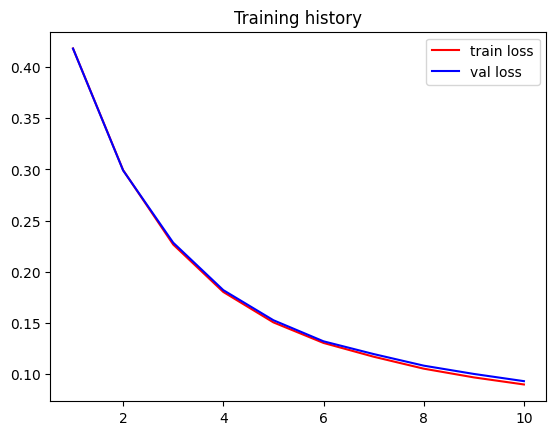

In [89]:
from matplotlib import pyplot as plt


plt.plot(
    [i + 1 for i in range(len(history))],
    [history[i][0] for i in range(len(history))],
    color="r",
    label="train loss",
)
plt.plot(
    [i + 1 for i in range(len(history))],
    [history[i][1] for i in range(len(history))],
    color="b",
    label="val loss",
)
plt.legend()
plt.title("Training history")
plt.show()


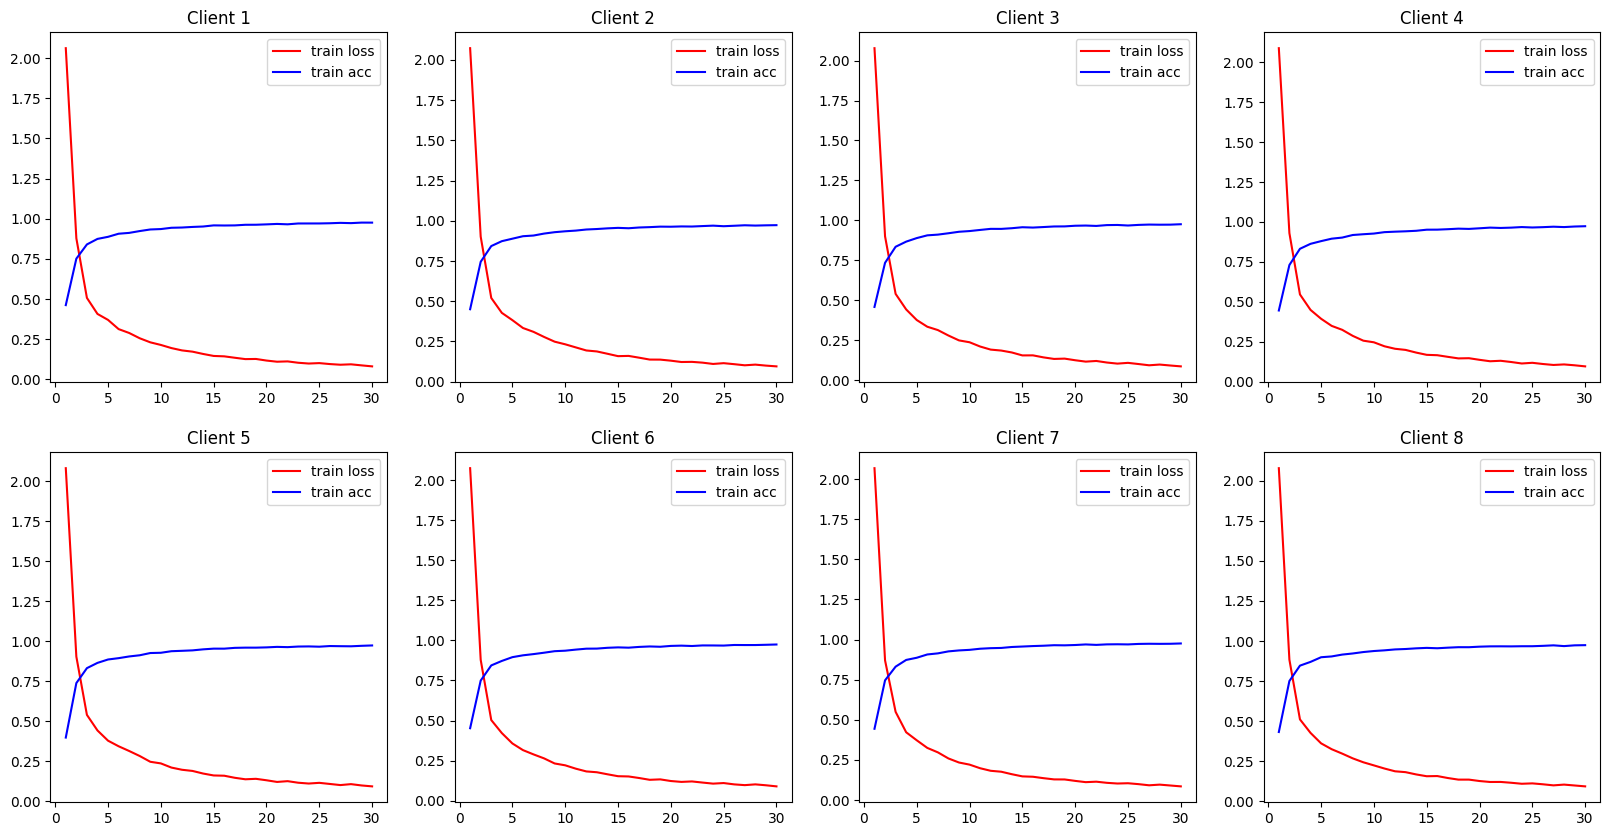

In [90]:
# PLOT THE TRAINING HISTORY OF CLIENTS
fig, axs = plt.subplots(2, 4, figsize=(20, 10))
for i in range(num_clients):
    axs[i // 4, i % 4].plot(
        [j + 1 for j in range(len(clients[i].history))],
        [clients[i].history[j][0] for j in range(len(clients[i].history))],
        color="r",
        label="train loss",
    )
    axs[i // 4, i % 4].plot(
        [j + 1 for j in range(len(clients[i].history))],
        [clients[i].history[j][1] for j in range(len(clients[i].history))],
        color="b",
        label="train acc",
    )
    axs[i // 4, i % 4].set_title("Client {}".format(i + 1))
    axs[i // 4, i % 4].legend()


<div dir=rtl id="">
<font face="XB Zar" size=4>
<font color="red" size=5>

ناهمگنی داده

</font>
<hr />

در این محیط بسیار محتمل است که داده کاربران مختلف از یک توزیع مشابه نباشند. این مورد می‌تواند برای دقت و محرمانگی مدل چالش ایجاد کند.

</font>
</div>

<div dir=rtl id="">
<font face="XB Zar" size=4>

برای این سناریو ابتدا داده ناهمگن سنتز می‌کنیم. این داده به این صورت است که هر کاربر داده‌ای از یک کلاس به خصوص دارد.

</font>
</div>

In [91]:
data_with_labels = []
for i in tqdm.tqdm(range(10)):
    data_with_labels.append(
        torch.utils.data.Subset(
            train_dataset,
            [j for j in range(len(train_dataset)) if train_dataset[j][1] == i],
        )
    )


100%|██████████| 10/10 [00:45<00:00,  4.54s/it]


<div dir=rtl id="">
<font face="XB Zar" size=4>

حال کلاسی را تعریف می‌کنیم تا این داده ناهمگن را به عنوان دیتاست لفاف‌بندی کند.

</font>
</div>

In [92]:
class HeteroDataset(torch.utils.data.Dataset):
    """
    Heterogeneous dataset.
    Args:
        dataset (torch.utils.data.Dataset): Dataset.
        label (int): Label.
    """

    def __init__(self, dataset, label):
        """
        Heterogeneous dataset.
        Args:
            dataset (torch.utils.data.Dataset): Dataset.
            label (int): Label.
        """
        self.dataset = dataset
        self.label = label

    def __getitem__(self, index):
        """
        Get item.
        Args:
            index (int): Index.
        Returns:
            tuple: Tuple of (data, label).
        """
        return self.dataset[index][0], self.label

    def __len__(self):
        return len(self.dataset)


<div dir=rtl id="">
<font face="XB Zar" size=4>

کاربران ساخته شده هر یک داده‌ای از سه کلاس به خصوص خواهند داشت.

</font>
</div>

In [93]:
clients = [
    Client("client_" + str(i), FederatedNet(), HeteroDataset(data_with_labels[i] + data_with_labels[i + 1] + data_with_labels[i + 2], i))
    for i in range(8)
]


<div dir=rtl id="">
<font face="XB Zar" size=4>

حال مجددا آموزش مدل را با این دادگان جدید انجام خواهیم داد.

</font>
</div>

In [94]:
global_net = to_device(FederatedNet(), device)
history = []
for i in range(10):
    print("Start Round {} ...".format(i + 1))
    curr_parameters = get_parameters(global_net)
    new_parameters = dict(
        [(layer_name, {"weight": 0, "bias": 0}) for layer_name in curr_parameters]
    )
    for client in clients:
        client_parameters = client.train(curr_parameters)
        fraction = client.get_dataset_size() / total_train_size
        for layer_name in client_parameters:
            new_parameters[layer_name]["weight"] += (
                fraction * client_parameters[layer_name]["weight"]
            )
            new_parameters[layer_name]["bias"] += (
                fraction * client_parameters[layer_name]["bias"]
            )
    apply_parameters(global_net, new_parameters)

    train_loss, train_acc = evaluate(global_net, train_dataset)
    dev_loss, dev_acc = evaluate(global_net, val_dataset)
    print(
        "After round {}, train_loss = {}, dev_loss = {}, dev_acc = {}\n".format(
            i + 1, round(train_loss, 4), round(dev_loss, 4), round(dev_acc, 4)
        )
    )
    history.append((train_loss, dev_loss))


Start Round 1 ...
client_0: Loss = 0.0002, Accuracy = 1.0
client_1: Loss = 0.0002, Accuracy = 1.0
client_2: Loss = 0.0002, Accuracy = 1.0
client_3: Loss = 0.0002, Accuracy = 1.0
client_4: Loss = 0.0002, Accuracy = 1.0
client_5: Loss = 0.0002, Accuracy = 1.0
client_6: Loss = 0.0002, Accuracy = 1.0
client_7: Loss = 0.0002, Accuracy = 1.0
After round 1, train_loss = 9.3376, dev_loss = 9.3993, dev_acc = 0.113

Start Round 2 ...
client_0: Loss = 0.0, Accuracy = 1.0
client_1: Loss = 0.0, Accuracy = 1.0
client_2: Loss = 0.0, Accuracy = 1.0
client_3: Loss = 0.0, Accuracy = 1.0
client_4: Loss = 0.0, Accuracy = 1.0
client_5: Loss = 0.0, Accuracy = 1.0
client_6: Loss = 0.0, Accuracy = 1.0
client_7: Loss = 0.0, Accuracy = 1.0
After round 2, train_loss = 673.6898, dev_loss = 678.1398, dev_acc = 0.0977

Start Round 3 ...
client_0: Loss = 0.0, Accuracy = 1.0
client_1: Loss = 0.0, Accuracy = 1.0
client_2: Loss = 0.0, Accuracy = 1.0
client_3: Loss = 0.0, Accuracy = 1.0
client_4: Loss = 0.0, Accuracy = 

<div dir=rtl id="">
<font face="XB Zar" size=4>

همان‌طور که ملاحظه می‌کنید دقت و عملکرد مدل دچار کاهش چشم‌گیری شده است. این به این دلیل است که آپدیت‌های مدل که از سمت کاربران ارسال می‌شود، بدون در نظر گرفتن ناهمگنی مدل بلکه تنها با در نظر گرفتن بهینه کردن مدل برای داده خودشان است.

</font>
</div>

<div dir=rtl id="">
<font face="XB Zar" size=4>
<font color="red" size=5>

حمله بازسازی ورودی

</font>
<hr />

حال می‌خواهیم حمله بازسازی ورودی را مطرح کنیم. همان‌طور که مستحضر هستید هدف اصلی یادگیری فدرال حفظ حریم خصوصی با عدم ارسال داده به سرور بود. اما در این حمله نشان داده می‌شود که امکان بازسازی تصویر ورودی وجود دارد.

</font>
</div>

<div dir=rtl id="">
<font face="XB Zar" size=4>

در این قسمت نت‌ورکی که حمله بر روی آن صورت می‌گیرد را پیاده‌سازی می‌کنیم. این نتورک بسیار ساده‌ است و از سه لایه خطی تشکیل شده است.

</font>
</div>

In [95]:
class TargetNetwork(torch.nn.Module):
    def __init__(self):
        super(TargetNetwork, self).__init__()
        self.first_part = torch.nn.Sequential(
            torch.nn.Linear(784, 500),
            torch.nn.ReLU(),
        )
        self.second_part = torch.nn.Sequential(
            torch.nn.Linear(500, 500),
            torch.nn.ReLU(),
            torch.nn.Linear(500, 10),
            torch.nn.Softmax(dim=-1),
        )

    def forward(self, x):
        return self.second_part(self.first_part(x))


In [96]:
target_network = to_device(TargetNetwork(), device)


<div dir=rtl id="">
<font face="XB Zar" size=4>

در این قسمت مدل حمله‌کننده را پیاده‌سازی می‌کنیم. این مدل خروجی لایه اول را دریافت می‌کند و با استفاده از دو لایه‌ای که خود دارد، خروجی مدل را بازسازی می‌کند.

</font>
</div>

In [97]:
class Attacker(torch.nn.Module):
    """
    Attacker.
    """

    def __init__(self):
        super(Attacker, self).__init__()
        self.layers = torch.nn.Sequential(
            torch.nn.Linear(500, 1000),
            torch.nn.ReLU(),
            torch.nn.Linear(1000, 784),
        )

    def forward(self, x):
        """
        Forward.
        Args:
            x (torch.Tensor): Input.
        Returns:
            torch.Tensor: Output.
        """
        return self.layers(x)


In [98]:
attacker = Attacker().to(device)

<div dir=rtl id="">
<font face="XB Zar" size=4>

حال مجموعه داده را بارگیری می‌کنیم.

</font>
</div>

In [99]:
# with flatten transform and to tensor
train_dataset = torchvision.datasets.MNIST(
    root="./working/",
    train=True,
    transform=torchvision.transforms.Compose(
        [
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Lambda(lambda x: x.flatten()),
        ]
    ),
    download=True,
)
test_dataset = torchvision.datasets.MNIST(
    root="./working/",
    train=False,
    transform=torchvision.transforms.Compose(
        [
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Lambda(lambda x: x.flatten()),
        ]
    ),
    download=True,
)

train_dataloader = DeviceDataLoader(
    torch.utils.data.DataLoader(train_dataset, batch_size), device
)
test_dataloader = DeviceDataLoader(
    torch.utils.data.DataLoader(test_dataset, batch_size), device
)


<div dir=rtl id="">
<font face="XB Zar" size=4>

حال مدل اصلی رو آموزش می‌دهیم.

</font>
</div>

In [100]:
optimizer = torch.optim.Adam(target_network.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss()
for epoch in range(10):
    losses = []
    for batch in train_dataloader:
        images, labels = batch
        optimizer.zero_grad()
        outputs = target_network(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    print("Epoch {}, loss = {}".format(epoch + 1, round(np.mean(losses), 4)))


Epoch 1, loss = 1.6713
Epoch 2, loss = 1.5394
Epoch 3, loss = 1.5009
Epoch 4, loss = 1.493
Epoch 5, loss = 1.4877
Epoch 6, loss = 1.486
Epoch 7, loss = 1.4834
Epoch 8, loss = 1.4802
Epoch 9, loss = 1.48
Epoch 10, loss = 1.4794


In [101]:
# calculate the accuracy
correct = 0
total = 0
with torch.no_grad():
    for batch in test_dataloader:
        images, labels = batch
        outputs = target_network(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print("Accuracy = {}".format(round(correct / total, 4)))


Accuracy = 0.977


<div dir=rtl id="">
<font face="XB Zar" size=4>

حال مدل حمله‌کننده را با استفاده از لایه اول مدل آموزش می‌دهیم.

</font>
</div>

In [102]:
optimizer = torch.optim.Adam(attacker.parameters(), lr=1e-4)

for data, targets in tqdm.tqdm(train_dataloader):
    data = data.to(device)
    targets = targets.to(device)
    optimizer.zero_grad()
    target_outputs = target_network.first_part(data)
    attack_outputs = attacker(target_outputs)
    loss = ((data - attack_outputs) ** 2).mean()
    loss.backward()
    optimizer.step()


100%|██████████| 469/469 [00:07<00:00, 63.80it/s]


<div dir=rtl id="">
<font face="XB Zar" size=4>

حال میخواهیم داده‌های ذخیره شده در مدل را بازسازی کنیم.

</font>
</div>

In [103]:
for data, targets in test_dataloader:
    target_outputs = target_network.first_part(data)
    recreated_data = attacker(target_outputs)


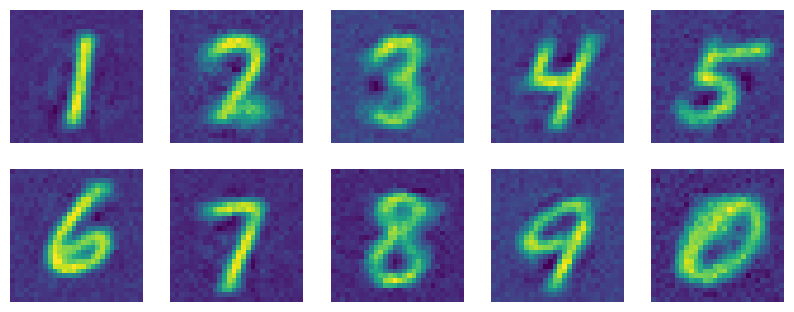

In [104]:
# plot 10 reconstructed images
plt.figure(figsize=(10, 10))
for i in range(10):
    plt.subplot(5, 5, i + 1)
    plt.imshow(recreated_data[i].cpu().detach().numpy().reshape(28, 28))
    plt.axis("off")
plt.show()


<div dir=rtl id="">
<font face="XB Zar" size=4>

همان‌طور که ملاحظه می‌کنید داده‌های ذخیره شده در مدل با دقت بالایی بازسازی شده‌اند.

</font>
</div>

## References

[1] Li, Q., Wen, Z., Wu, Z., Hu, S., Wang, N., Li, Y., ... & He, B. (2021). A survey on federated learning systems: vision, hype and reality for data privacy and protection. IEEE Transactions on Knowledge and Data Engineering.

[2] Lyu, L., Yu, H., & Yang, Q. (2020). Threats to federated learning: A survey. arXiv preprint arXiv:2003.02133.